# Tutorial01
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction

In this tutorial, we build a simple classifier to classify the points in the 2D Gaussian dataset by minimizing the empirical risk $R(\omega)$ using the **binary cross-entropy loss**. That loss function is typically used to build a binary (that is, 2-class) classifier.
The binary cross-entropy loss is defined by 

$$L(y, f) = - [y \log f + (1 - y) \log(1-f)],$$ 

with the discrete targets $y \in \{0, 1\}$. From

\begin{align*}
0 & = \int \, \frac{\partial L(y, f)}{\partial f} \, p(y | \boldsymbol{x}) \, dy, \quad \text{ we see that}\\
    & = \int \,  \left( \frac{y}{f} - \frac{(1 - y)}{1-f}  \right) p(y | \boldsymbol{x}) \, dy,\\
    & = \frac{p(y=1 | \boldsymbol{x})}{f} - \frac{p(y=0 | \boldsymbol{x})}{1 -f},\\
   \frac{f}{1-f} & = \frac{p(y=1 | \boldsymbol{x})}{p(y=0 | \boldsymbol{x})},\quad \implies f  = p(y=1 | \boldsymbol{x}) .
\end{align*}

Again, we stress that this conclusion is independent of the details of the model $f(\boldsymbol{x}, \boldsymbol{\omega})$.

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can't find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
DATAFILE  = '../data/two2dnormals.csv'
MODELFILE = 'nnmodel.dict'

NTRAIN = 80000
NVALID =  5000
NTEST  = 15000

TARGET = 'target'
FEATURES = ['x1', 'x2']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Exact density

Use the `%%writefile` command to write the cell contents to a file. The contents of file can be imported into another notebook providing a simple way to share code betweeen notebooks.

In [3]:
%%writefile exactdensity.py
import numpy as np
import scipy.stats as st

class ExactDensity:
    def __init__(self):
        self.rv1 = st.multivariate_normal(mean=[0.25, -0.25], 
                                          cov=[[0.20, 0.24], 
                                               [0.24, 0.40]])
        
        self.rv2 = st.multivariate_normal(mean=[-0.10, 0.10], 
                                          cov=[[0.60, 0.40], 
                                               [0.40, 0.30]])

    def grid(self, xmin=-1, xmax=1, ymin=-1, ymax=1, N=100):
        xstep = (xmax-xmin)/N
        ystep = (ymax-ymin)/N
        x1, x2 = np.mgrid[xmin:xmax+xstep/2:xstep, ymin:ymax+ystep/2:ystep]
        return x1, x2
        
    def __call__(self, x1, x2):
        # compute density at a grid of (x1, x2) points
        pos= np.dstack((x1, x2)) 
        p1 = self.rv1.pdf(pos)
        p0 = self.rv2.pdf(pos)
        return (p1 + p0)/2

    def prob(self, x1, x2):
        # compute p(y=1|x) at a grid of (x1, x2) points
        pos= np.dstack((x1, x2))
        p1 = self.rv1.pdf(pos)
        p0 = self.rv2.pdf(pos)
        return p1 / (p1 + p0)

Overwriting exactdensity.py


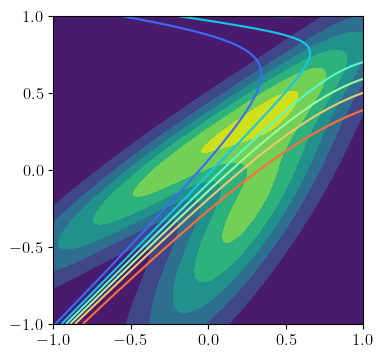

In [4]:
from exactdensity import ExactDensity

fexact = ExactDensity()
x1, x2 = fexact.grid()

fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)

tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax.set_xticks(tickmarks)
ax.set_yticks(tickmarks)

ax.contourf(x1, x2, fexact(x1, x2))
ax.contour(x1, x2, fexact.prob(x1, x2), cmap='rainbow')
plt.show()

## Load data

In [5]:
!ls 

__pycache__               nnmodel.dict              tutorial01.dict
dnnutil.py                nnmodel.py                tutorial01.ipynb
exactdensity.py           perceptron.ipynb          tutorial01_evaluate.ipynb
generate_2d_data.ipynb    perceptron.pdf            two2dnormals.png
model.py                  perceptron.png            two2dnormals1K.png
monitor_losses.py         test01.ipynb


In [6]:
df = pd.read_csv(DATAFILE)
print(len(df))
df[:10]

100000


,x1,x2,target
0,-0.665786,-0.574222,0.0
1,-0.213577,-0.173010,0.0
2,0.236111,-0.723421,1.0
3,0.160948,0.490774,0.0
4,-0.355925,-0.615319,1.0
5,0.695868,0.483321,1.0
6,-0.039668,0.265816,0.0
7,0.079798,0.062791,0.0
8,-2.130000,-1.338907,0.0
9,0.163297,0.088248,0.0


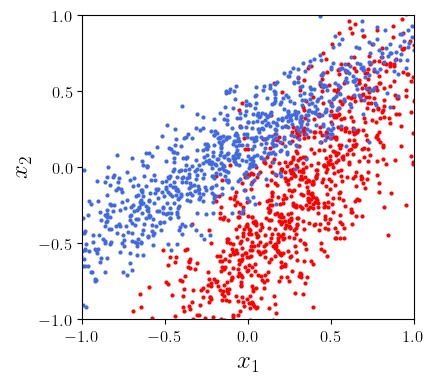

In [7]:
def plot_data():
    
    fig = plt.figure(figsize=(4.5, 4))
    
    ax  = fig.add_subplot(111)
    
    tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    ax.set_xlim(-1, 1)
    ax.set_xlabel(r'$x_1$', fontsize=18)
    ax.set_xticks(tickmarks)
    
    ax.set_ylim(-1, 1)
    ax.set_ylabel(r'$x_2$', fontsize=18)
    ax.set_yticks(tickmarks)
    
    d1 = df[df.target > 0.5]
    xp, yp = d1.x1[:1000], d1.x2[:1000]
    ax.scatter(xp, yp, s=4.0, color='red')
    
    d2 = df[df.target < 0.5]
    xp, yp = d2.x1[:1000], d2.x2[:1000]
    ax.scatter(xp, yp, s=4.0, color='royalblue');
    
    fig.tight_layout()
    
    plt.show()

plot_data()

## Split data

In [8]:
train_data  = df[:NTRAIN]
print(len(train_data))

valid_data  = df[NTRAIN:NTRAIN+NVALID]
print(len(valid_data))

test_data = df[NTRAIN+NVALID:]
print(len(test_data))

80000
5000
15000


## Save training data

In [9]:
test_data.to_csv('../data/testdata.csv', index=False)

## Convert to tensors

In [9]:
def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(DEVICE)
    y = torch.tensor(df[target].to_numpy()).float().to(DEVICE)
    return x, y

train_x, train_y = dataframe2tensor(train_data, TARGET, FEATURES)
valid_x, valid_y = dataframe2tensor(valid_data, TARGET, FEATURES)
test_x,  test_y  = dataframe2tensor(test_data,  TARGET, FEATURES)

train_x.shape, train_y.shape

(torch.Size([80000, 2]), torch.Size([80000]))

## Some ML Utilities

In [10]:
# Note: there are several average loss functions available 
# in PyTorch, such as nn.CrossEntropyLoss(), but it's useful 
# to know how to create your own.
def average_quadratic_loss(f, y):
    # f and t must be of the same shape
    losses = (f - y)**2
    return torch.mean(losses)

def average_binary_cross_entropy_loss(f, y):
    # f and t must be of the same shape
    # Note: because of our use of the "where" function, the 
    # precise values of the targets doesn't matter so long as for
    # one class y < 0.5 and the other y > 0.5
    losses = -torch.where(y > 0.5, torch.log(f), torch.log(1 - f))
    return torch.mean(losses)

def get_batch(x, y, batch_size, ii):
    # cycle through batches of training data sequentially
    K = int(len(x) / batch_size + 0.5) # number of batches / epoch
    jj = ii % K
    start = jj * batch_size
    end = start + batch_size - 1
    if end > len(x)-1:
        end = len(x)-1
    return x[start: end+1], y[start: end+1], jj

def get_random_batch(x, y, batch_size):
    # selects at random "batch_size" integers from 
    # the range [0, batch_size-1] corresponding to the
    # row indices of the training data
    rows = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[rows], y[rows]
        
def validate(model, avloss, x, y):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(x).reshape(y.shape)
    return avloss(f, y)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss_curve(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 3.8))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')

    plt.show()

## Define a fully-connected neural network

### $\texttt{SiLU}(x)$

$$\text{silu}(x) = x \, \sigma(x), \text{where } \sigma(x) \text{ is the logistic.}$$


### LayerNorm

$$y = \frac{(x - E[x])}{\sqrt{V(x)}},$$

where the averaging is over the layer.

In [11]:
%%writefile nnmodel.py
import torch.nn as nn
H = 15
model = nn.Sequential(nn.Linear(2, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, 1), nn.Sigmoid())

Overwriting nnmodel.py


## Train model

In [12]:
from nnmodel import model

learning_rate = 1.e-4
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate) 

n_iterations  = 50001
n_batch  = 128
n_step   = 10
n_valid  = len(valid_x)
train_x2 = train_x[:n_valid]
train_y2 = train_y[:n_valid]

emprisk  = average_binary_cross_entropy_loss

|       81|    50000|2.527e-01|2.551e-01|


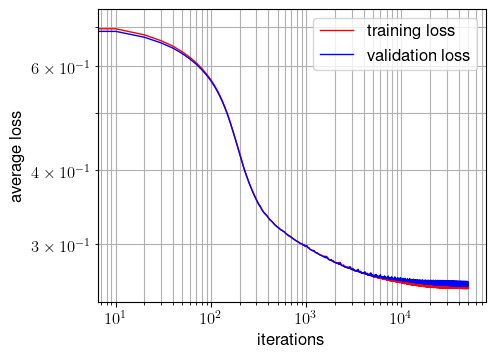

In [13]:
USE_SEQUENTIAL_BATCHES = True

epoch = 0

X = []
T = []
V = []

min_avloss = float('inf')

for ii in range(n_iterations):

    # clear previous gradients
    
    optimizer.zero_grad()
    
    # set mode to training so that training specific 
    # operations such as dropout are enabled.
    
    model.train()

    # get a batch of data 

    if USE_SEQUENTIAL_BATCHES:
        x, y, jj = get_batch(train_x, train_y, n_batch, ii)
        if jj == 0:
            epoch += 1
    else:
        x, y = get_random_batch(train_x, train_y, n_batch)  
        
    f = model(x).reshape(y.shape)

    R = emprisk(f, y)
    
    R.backward()  # compute gradients of with respect to NN parameters

    optimizer.step()    # advance one step in the space of NN parameters

    if ii % n_step == 0:
           
        t_loss = validate(model, emprisk, train_x2, train_y2).detach()
        v_loss = validate(model, emprisk, valid_x,  valid_y).detach()

        print(f'\r|{epoch:9d}|{ii:9d}|{t_loss:9.3e}|{v_loss:9.3e}|', end='')

        X.append(ii)
        T.append(float(t_loss))
        V.append(float(v_loss))

        if v_loss < 0.995 * min_avloss:
            min_avloss = v_loss
            torch.save(model.state_dict(), MODELFILE)
        
print()

plot_loss_curve([X, T, V])